<a href="https://colab.research.google.com/github/adunStudio/hanghae99_plusAI_2/blob/main/1%EC%A3%BC%EC%B0%A8/1_3_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [FEEDBACK] 맥 환경입니다. CUDA가 아닌 MPS 사용해도 될까요?

| **항목**          | **CUDA**                                  | **MPS (Metal Performance Shaders)**        |
|-------------------|------------------------------------------|-------------------------------------------|
| **제작사**       | NVIDIA                                   | Apple                                     |
| **호환 하드웨어** | NVIDIA GPU 전용                         | Apple Silicon (M1, M2), 일부 Intel Mac GPU |
| **플랫폼**       | Windows, Linux, macOS (NVIDIA GPU만)     | macOS 및 iOS                              |
| **프로그래밍 모델** | CUDA C/C++, Python, cuDNN 등 지원       | Metal API 기반, Python (PyTorch MPS)       |
| **프레임워크 호환성** | TensorFlow, PyTorch, MXNet, etc.         | PyTorch (MPS 백엔드)                      |
| **생태계**       | 매우 광범위, NVIDIA GPU 생태계에 집중    | Apple 생태계 내에 한정                    |
| **API 및 라이브러리** | CUDA Core, cuDNN, cuBLAS, TensorRT 등    | Metal Performance Shaders API             |

In [1]:
import torch
print(f"MPS 장치를 지원하도록 build가 되었는가? {torch.backends.mps.is_built()}")
print(f"MPS 장치가 사용 가능한가? {torch.backends.mps.is_available()}")

device = torch.device("mps")

MPS 장치를 지원하도록 build가 되었는가? True
MPS 장치가 사용 가능한가? True


# MNIST 실습

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# [MY CODE] Test data 준비하기 1/2


In [13]:
# 데이터셋 전처리:
# 1. PIL 이미지 또는 NumPy 배열 → PyTorch Tensor로 변환
# 2. 이미지를 Tensor로 변환 (픽셀 값을 [0, 1] 범위로 정규화)
# 3. 이미지 데이터를 [-1, 1] 범위로 스케일링
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST 학습 데이터셋 로드
train_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform,
)

# MNIST 테스트 데이터셋 로드
test_set = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform,
)

60000
torch.Size([1, 28, 28]) 5


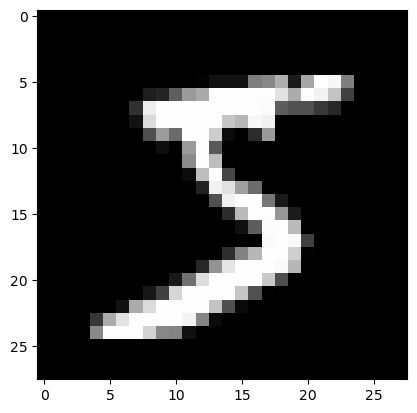

In [4]:
from matplotlib import pyplot as plt

print(len(train_set))
print(train_set[0][0].shape, train_set[0][1])
plt.imshow(train_set[0][0][0], cmap='gray')
# 60,000개의 이미지로 구성되어있다.
# [1, 28, 28]: 1채널(흑백), 28 x 28 크기 이미지

# [MY CODE] Test data 준비하기 2/2


In [5]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
)

In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


In [7]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [8]:
from torch import nn


class Model(nn.Module):
    def __init__(self, input_dim, num_dim, num_classes):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, num_dim)
        self.layer2 = nn.Linear(num_dim, num_dim)
        self.layer3 = nn.Linear(num_dim, num_classes)  # 최종 출력 레이어

        self.act = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # 입력 평탄화
        x = self.act(self.layer1(x))       # 첫 번째 레이어 + ReLU
        x = self.act(self.layer2(x))       # 두 번째 레이어 + ReLU
        x = self.layer3(x)                 # 세 번째 레이어 (로짓 반환)
        # CrossEntropyLoss는 Softmax를 내부적으로 자동 적용한다.
        # Softmax가 두 번 적용되면 랭크는 같으나 값의 차이가 생긴다.
        return x


model = Model(28 * 28 * 1, 1024, 10)

# [MY CODE] nn.CrossEntropyLoss 적용하기

In [9]:
from torch.optim import SGD

lr = 0.001
model = model.to(device)

# 손실 함수: 교차 엔트로피 손실 (분류 문제에서 사용)
criterion = nn.CrossEntropyLoss()

optimizer = SGD(model.parameters(), lr=lr)

train_accuracies = []
test_accuracies = []

In [10]:
import time

num_epochs = 100

for epoch in range(num_epochs):
  start_time = time.time()  # 에포크 시작 시간 기록
  total_loss = 0.
  model.train()  # 학습 모드

  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    average_loss = total_loss / len(train_loader)

  end_time = time.time()
  epoch_time = end_time - start_time  # 에포크 실행 시간 계산

  with torch.no_grad():
    model.eval()  # 평가 모드
    train_acc = accuracy(model, train_loader)  # 학습 데이터 정확도
    test_acc = accuracy(model, test_loader)    # 테스트 데이터 정확도

  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

  print(f"Epoch {epoch+1:3d} |"
        f" Time: {epoch_time:.2f} seconds |"
        f" Loss: {average_loss:.2f} |"
        f" Train Acc: {train_acc:.3f} |"
        f" Test Acc: {test_acc:.3f}")

Epoch   1 | Time: 4.02 seconds | Loss: 2.26 | Train Acc: 0.378 | Test Acc: 0.392
Epoch   2 | Time: 4.09 seconds | Loss: 2.15 | Train Acc: 0.507 | Test Acc: 0.525
Epoch   3 | Time: 3.72 seconds | Loss: 2.04 | Train Acc: 0.602 | Test Acc: 0.618
Epoch   4 | Time: 3.65 seconds | Loss: 1.91 | Train Acc: 0.656 | Test Acc: 0.669
Epoch   5 | Time: 3.91 seconds | Loss: 1.75 | Train Acc: 0.699 | Test Acc: 0.711
Epoch   6 | Time: 3.53 seconds | Loss: 1.58 | Train Acc: 0.729 | Test Acc: 0.741
Epoch   7 | Time: 3.49 seconds | Loss: 1.40 | Train Acc: 0.757 | Test Acc: 0.773
Epoch   8 | Time: 3.50 seconds | Loss: 1.24 | Train Acc: 0.779 | Test Acc: 0.792
Epoch   9 | Time: 3.88 seconds | Loss: 1.11 | Train Acc: 0.794 | Test Acc: 0.804
Epoch  10 | Time: 3.65 seconds | Loss: 0.99 | Train Acc: 0.808 | Test Acc: 0.817
Epoch  11 | Time: 4.44 seconds | Loss: 0.90 | Train Acc: 0.817 | Test Acc: 0.825
Epoch  12 | Time: 3.76 seconds | Loss: 0.83 | Train Acc: 0.827 | Test Acc: 0.835
Epoch  13 | Time: 4.03 secon

# [LOG] 학습 과정에서의 Epoch별 손실값 출력

```
Epoch   1 | Time: 4.02 seconds | Loss: 2.26 | Train Acc: 0.378 | Test Acc: 0.392
Epoch   2 | Time: 4.09 seconds | Loss: 2.15 | Train Acc: 0.507 | Test Acc: 0.525
Epoch   3 | Time: 3.72 seconds | Loss: 2.04 | Train Acc: 0.602 | Test Acc: 0.618
Epoch   4 | Time: 3.65 seconds | Loss: 1.91 | Train Acc: 0.656 | Test Acc: 0.669
Epoch   5 | Time: 3.91 seconds | Loss: 1.75 | Train Acc: 0.699 | Test Acc: 0.711
Epoch   6 | Time: 3.53 seconds | Loss: 1.58 | Train Acc: 0.729 | Test Acc: 0.741
Epoch   7 | Time: 3.49 seconds | Loss: 1.40 | Train Acc: 0.757 | Test Acc: 0.773
Epoch   8 | Time: 3.50 seconds | Loss: 1.24 | Train Acc: 0.779 | Test Acc: 0.792
Epoch   9 | Time: 3.88 seconds | Loss: 1.11 | Train Acc: 0.794 | Test Acc: 0.804
Epoch  10 | Time: 3.65 seconds | Loss: 0.99 | Train Acc: 0.808 | Test Acc: 0.817
Epoch  11 | Time: 4.44 seconds | Loss: 0.90 | Train Acc: 0.817 | Test Acc: 0.825
Epoch  12 | Time: 3.76 seconds | Loss: 0.83 | Train Acc: 0.827 | Test Acc: 0.835
Epoch  13 | Time: 4.03 seconds | Loss: 0.77 | Train Acc: 0.833 | Test Acc: 0.840
Epoch  14 | Time: 3.84 seconds | Loss: 0.71 | Train Acc: 0.840 | Test Acc: 0.847
Epoch  15 | Time: 3.90 seconds | Loss: 0.67 | Train Acc: 0.844 | Test Acc: 0.852
Epoch  16 | Time: 3.51 seconds | Loss: 0.64 | Train Acc: 0.850 | Test Acc: 0.857
Epoch  17 | Time: 3.64 seconds | Loss: 0.61 | Train Acc: 0.854 | Test Acc: 0.861
Epoch  18 | Time: 3.55 seconds | Loss: 0.58 | Train Acc: 0.857 | Test Acc: 0.865
Epoch  19 | Time: 3.87 seconds | Loss: 0.56 | Train Acc: 0.862 | Test Acc: 0.869
Epoch  20 | Time: 3.69 seconds | Loss: 0.54 | Train Acc: 0.865 | Test Acc: 0.872
Epoch  21 | Time: 3.50 seconds | Loss: 0.52 | Train Acc: 0.867 | Test Acc: 0.875
Epoch  22 | Time: 3.50 seconds | Loss: 0.51 | Train Acc: 0.870 | Test Acc: 0.877
Epoch  23 | Time: 3.52 seconds | Loss: 0.49 | Train Acc: 0.872 | Test Acc: 0.879
Epoch  24 | Time: 3.50 seconds | Loss: 0.48 | Train Acc: 0.874 | Test Acc: 0.881
Epoch  25 | Time: 3.51 seconds | Loss: 0.47 | Train Acc: 0.876 | Test Acc: 0.884
Epoch  26 | Time: 3.51 seconds | Loss: 0.46 | Train Acc: 0.878 | Test Acc: 0.885
Epoch  27 | Time: 3.50 seconds | Loss: 0.45 | Train Acc: 0.880 | Test Acc: 0.886
Epoch  28 | Time: 3.56 seconds | Loss: 0.44 | Train Acc: 0.882 | Test Acc: 0.888
Epoch  29 | Time: 3.49 seconds | Loss: 0.43 | Train Acc: 0.883 | Test Acc: 0.888
Epoch  30 | Time: 3.51 seconds | Loss: 0.43 | Train Acc: 0.884 | Test Acc: 0.889
Epoch  31 | Time: 3.51 seconds | Loss: 0.42 | Train Acc: 0.886 | Test Acc: 0.891
Epoch  32 | Time: 3.49 seconds | Loss: 0.41 | Train Acc: 0.887 | Test Acc: 0.892
Epoch  33 | Time: 3.49 seconds | Loss: 0.41 | Train Acc: 0.889 | Test Acc: 0.892
Epoch  34 | Time: 3.49 seconds | Loss: 0.40 | Train Acc: 0.890 | Test Acc: 0.894
Epoch  35 | Time: 3.48 seconds | Loss: 0.40 | Train Acc: 0.891 | Test Acc: 0.893
Epoch  36 | Time: 3.48 seconds | Loss: 0.39 | Train Acc: 0.891 | Test Acc: 0.895
Epoch  37 | Time: 3.53 seconds | Loss: 0.39 | Train Acc: 0.892 | Test Acc: 0.896
Epoch  38 | Time: 3.48 seconds | Loss: 0.39 | Train Acc: 0.893 | Test Acc: 0.897
Epoch  39 | Time: 3.51 seconds | Loss: 0.38 | Train Acc: 0.894 | Test Acc: 0.897
Epoch  40 | Time: 3.50 seconds | Loss: 0.38 | Train Acc: 0.895 | Test Acc: 0.898
Epoch  41 | Time: 3.49 seconds | Loss: 0.38 | Train Acc: 0.895 | Test Acc: 0.899
Epoch  42 | Time: 3.50 seconds | Loss: 0.37 | Train Acc: 0.896 | Test Acc: 0.900
Epoch  43 | Time: 3.49 seconds | Loss: 0.37 | Train Acc: 0.897 | Test Acc: 0.900
Epoch  44 | Time: 3.54 seconds | Loss: 0.37 | Train Acc: 0.897 | Test Acc: 0.901
Epoch  45 | Time: 3.48 seconds | Loss: 0.36 | Train Acc: 0.898 | Test Acc: 0.901
Epoch  46 | Time: 3.50 seconds | Loss: 0.36 | Train Acc: 0.898 | Test Acc: 0.902
Epoch  47 | Time: 3.49 seconds | Loss: 0.36 | Train Acc: 0.899 | Test Acc: 0.903
Epoch  48 | Time: 3.49 seconds | Loss: 0.36 | Train Acc: 0.899 | Test Acc: 0.904
Epoch  49 | Time: 3.51 seconds | Loss: 0.35 | Train Acc: 0.900 | Test Acc: 0.904
Epoch  50 | Time: 3.51 seconds | Loss: 0.35 | Train Acc: 0.901 | Test Acc: 0.904
Epoch  51 | Time: 3.50 seconds | Loss: 0.35 | Train Acc: 0.901 | Test Acc: 0.905
Epoch  52 | Time: 3.50 seconds | Loss: 0.35 | Train Acc: 0.901 | Test Acc: 0.904
Epoch  53 | Time: 3.52 seconds | Loss: 0.34 | Train Acc: 0.902 | Test Acc: 0.905
Epoch  54 | Time: 3.55 seconds | Loss: 0.34 | Train Acc: 0.903 | Test Acc: 0.906
Epoch  55 | Time: 3.49 seconds | Loss: 0.34 | Train Acc: 0.903 | Test Acc: 0.906
Epoch  56 | Time: 3.53 seconds | Loss: 0.34 | Train Acc: 0.904 | Test Acc: 0.908
Epoch  57 | Time: 3.49 seconds | Loss: 0.34 | Train Acc: 0.904 | Test Acc: 0.907
Epoch  58 | Time: 3.49 seconds | Loss: 0.33 | Train Acc: 0.905 | Test Acc: 0.908
Epoch  59 | Time: 3.51 seconds | Loss: 0.33 | Train Acc: 0.905 | Test Acc: 0.909
Epoch  60 | Time: 3.48 seconds | Loss: 0.33 | Train Acc: 0.906 | Test Acc: 0.909
Epoch  61 | Time: 3.46 seconds | Loss: 0.33 | Train Acc: 0.906 | Test Acc: 0.909
Epoch  62 | Time: 3.47 seconds | Loss: 0.33 | Train Acc: 0.907 | Test Acc: 0.910
Epoch  63 | Time: 3.58 seconds | Loss: 0.33 | Train Acc: 0.907 | Test Acc: 0.910
Epoch  64 | Time: 3.56 seconds | Loss: 0.33 | Train Acc: 0.908 | Test Acc: 0.911
Epoch  65 | Time: 3.47 seconds | Loss: 0.32 | Train Acc: 0.908 | Test Acc: 0.911
Epoch  66 | Time: 3.50 seconds | Loss: 0.32 | Train Acc: 0.908 | Test Acc: 0.911
Epoch  67 | Time: 3.52 seconds | Loss: 0.32 | Train Acc: 0.909 | Test Acc: 0.911
Epoch  68 | Time: 3.49 seconds | Loss: 0.32 | Train Acc: 0.909 | Test Acc: 0.912
Epoch  69 | Time: 3.49 seconds | Loss: 0.32 | Train Acc: 0.909 | Test Acc: 0.912
Epoch  70 | Time: 3.47 seconds | Loss: 0.32 | Train Acc: 0.910 | Test Acc: 0.911
Epoch  71 | Time: 3.50 seconds | Loss: 0.32 | Train Acc: 0.910 | Test Acc: 0.912
Epoch  72 | Time: 3.51 seconds | Loss: 0.31 | Train Acc: 0.910 | Test Acc: 0.913
Epoch  73 | Time: 3.48 seconds | Loss: 0.31 | Train Acc: 0.911 | Test Acc: 0.913
Epoch  74 | Time: 3.70 seconds | Loss: 0.31 | Train Acc: 0.911 | Test Acc: 0.913
Epoch  75 | Time: 3.55 seconds | Loss: 0.31 | Train Acc: 0.911 | Test Acc: 0.914
Epoch  76 | Time: 3.51 seconds | Loss: 0.31 | Train Acc: 0.912 | Test Acc: 0.914
Epoch  77 | Time: 3.59 seconds | Loss: 0.31 | Train Acc: 0.912 | Test Acc: 0.914
Epoch  78 | Time: 3.48 seconds | Loss: 0.31 | Train Acc: 0.912 | Test Acc: 0.914
Epoch  79 | Time: 3.48 seconds | Loss: 0.31 | Train Acc: 0.913 | Test Acc: 0.915
Epoch  80 | Time: 3.77 seconds | Loss: 0.30 | Train Acc: 0.913 | Test Acc: 0.915
Epoch  81 | Time: 3.52 seconds | Loss: 0.30 | Train Acc: 0.913 | Test Acc: 0.915
Epoch  82 | Time: 3.51 seconds | Loss: 0.30 | Train Acc: 0.913 | Test Acc: 0.915
Epoch  83 | Time: 3.49 seconds | Loss: 0.30 | Train Acc: 0.914 | Test Acc: 0.917
Epoch  84 | Time: 3.49 seconds | Loss: 0.30 | Train Acc: 0.914 | Test Acc: 0.917
Epoch  85 | Time: 3.50 seconds | Loss: 0.30 | Train Acc: 0.914 | Test Acc: 0.917
Epoch  86 | Time: 3.49 seconds | Loss: 0.30 | Train Acc: 0.915 | Test Acc: 0.918
Epoch  87 | Time: 3.51 seconds | Loss: 0.30 | Train Acc: 0.915 | Test Acc: 0.918
Epoch  88 | Time: 3.50 seconds | Loss: 0.30 | Train Acc: 0.915 | Test Acc: 0.917
Epoch  89 | Time: 3.51 seconds | Loss: 0.30 | Train Acc: 0.915 | Test Acc: 0.918
Epoch  90 | Time: 3.50 seconds | Loss: 0.29 | Train Acc: 0.916 | Test Acc: 0.919
Epoch  91 | Time: 3.53 seconds | Loss: 0.29 | Train Acc: 0.916 | Test Acc: 0.918
Epoch  92 | Time: 3.80 seconds | Loss: 0.29 | Train Acc: 0.916 | Test Acc: 0.919
Epoch  93 | Time: 3.56 seconds | Loss: 0.29 | Train Acc: 0.917 | Test Acc: 0.919
Epoch  94 | Time: 3.65 seconds | Loss: 0.29 | Train Acc: 0.917 | Test Acc: 0.919
Epoch  95 | Time: 3.71 seconds | Loss: 0.29 | Train Acc: 0.917 | Test Acc: 0.919
Epoch  96 | Time: 3.67 seconds | Loss: 0.29 | Train Acc: 0.917 | Test Acc: 0.919
Epoch  97 | Time: 3.68 seconds | Loss: 0.29 | Train Acc: 0.917 | Test Acc: 0.920
Epoch  98 | Time: 3.49 seconds | Loss: 0.29 | Train Acc: 0.918 | Test Acc: 0.920
Epoch  99 | Time: 3.48 seconds | Loss: 0.29 | Train Acc: 0.918 | Test Acc: 0.920
Epoch 100 | Time: 3.52 seconds | Loss: 0.28 | Train Acc: 0.918 | Test Acc: 0.921
```

In [11]:
idx = 3

x = train_set[idx][0][None]  # (1, 1, 28, 28)
x = x.to(device)

print(model(x))
print(train_set[idx][1])

tensor([[-6.1188,  6.9846,  2.4710,  0.9877, -2.5038, -0.6292, -1.8601, -0.3900,
          2.3598, -1.9594]], device='mps:0', grad_fn=<LinearBackward0>)
1


여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.

# [MY CODE] 학습을 진행한 후, epoch에 따른 model의 train과 test data에 대한 정확도 plot하기

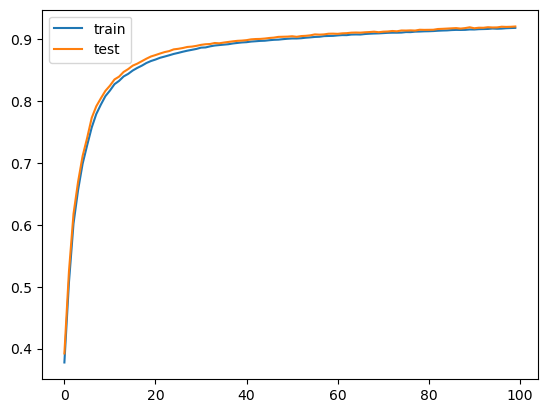

In [12]:
import numpy as np

def plot_acc(train_accuracies, test_accuracies, label1='train', label2='test'):
  x = np.arange(len(train_accuracies))

  plt.plot(x, train_accuracies, label=label1)
  plt.plot(x, test_accuracies, label=label2)
  plt.legend()
  plt.show()

plot_acc(train_accuracies, test_accuracies)